# 0. Setup and Imports

In [95]:
import numpy as np
import pandas as pd 
import copy

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import matplotlib.pyplot as plt


# 1. Read the data

This is from Keras

In [70]:
m_train = 50000
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train, x_valid = x_train_full[:m_train]/255.0,  x_train_full[m_train:]/255.0
y_train, y_valid = y_train_full[:m_train],  y_train_full[m_train:] 
x_test = x_test/255.0

Let's check the train and test set shapes

In [71]:
# train set
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
# validation set 
print(f"x_valid shape: {x_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")
# test set 
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

x_train shape: (50000, 28, 28)
y_train shape: (50000,)
x_valid shape: (10000, 28, 28)
y_valid shape: (10000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


And let's look at the counts in each set:

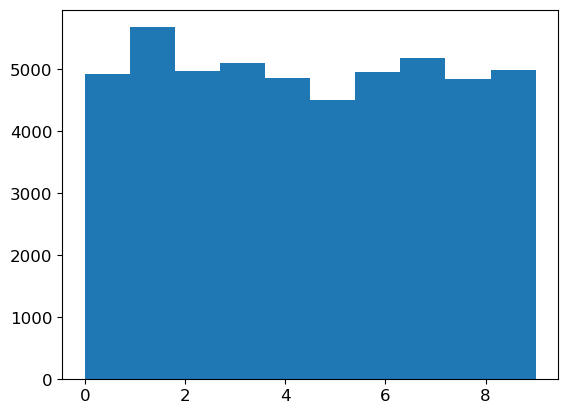

In [72]:
plt.hist(y_train)
plt.show()

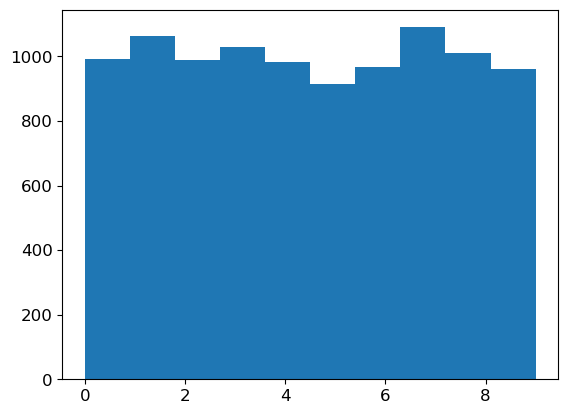

In [73]:
plt.hist(y_valid)
plt.show()

In [74]:
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts/np.sum(counts))).T)

[[0.     0.098 ]
 [1.     0.1135]
 [2.     0.1032]
 [3.     0.101 ]
 [4.     0.0982]
 [5.     0.0892]
 [6.     0.0958]
 [7.     0.1028]
 [8.     0.0974]
 [9.     0.1009]]


Let's look at a random case:

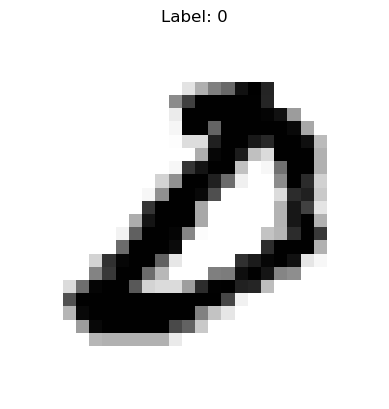

In [75]:
_test_n = np.random.randint(low= 0, high=50000)
plt.imshow(255*x_train[_test_n], cmap="binary")
plt.title(f"Label: {y_train[_test_n]}")
plt.axis('off')
plt.show()

# 2. Models 

We follow chapter 10 and create multiple models, try to fine tune them.

## 2.1. model 1

This is a simple sequential model with 2 Hidden layers:

In [80]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model_1 = keras.models.Sequential(
    [
        # 0. input layer: A flatten layer with the shape 28*28. 
        keras.layers.Flatten(
            input_shape = [28,28],
            name = "flatten_input"
        ),
        # 
        # 1. First Hidden layer: 
        keras.layers.Dense(
            units = 300,
            activation = 'relu',
            name = "h1"
        ),
        #
        # 2. Second Hiiden layer
        keras.layers.Dense(
            units = 100,
            activation = 'relu',
            name = 'h2'
        ),
        #
        # 3. output layer with 10 units corresponding to 10 digits. 
        # We use 'softmax' activation function, to get probabilities. 
        keras.layers.Dense(
            units = 10,
            activation = 'softmax',
            name = 'output' 
        )
    ]
)
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_input (Flatten)     (None, 784)               0         
                                                                 
 h1 (Dense)                  (None, 300)               235500    
                                                                 
 h2 (Dense)                  (None, 100)               30100     
                                                                 
 output (Dense)              (None, 10)                1010      
                                                                 
Total params: 266610 (1.02 MB)
Trainable params: 266610 (1.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


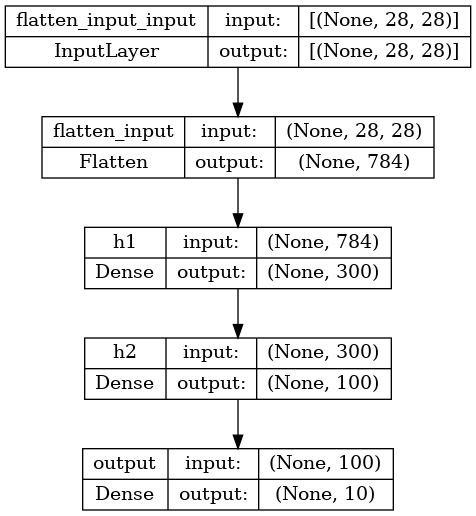

In [81]:
keras.utils.plot_model(model_1, "model_1.png", show_shapes=True)

In [94]:
np.logspace(
    start = -3,
    stop = 1,
    num = 2,
    endpoint = True,
    base= 10
)

array([1.e-03, 1.e+01])

In [126]:
histories_lr = {}

keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

learning_rate_list = np.logspace(
    start = -4,
    stop = 1,
    num = 6,
    endpoint = True,
    base= 10
)

counter = 0

for lr in learning_rate_list:
    print(f" lr is {lr}")
    # copy the base model
    lr_model = keras.models.Sequential(
        [
            # 0. input layer: A flatten layer with the shape 28*28. 
            keras.layers.Flatten(
                input_shape = [28,28],
                name = "flatten_input"
            ),
            # 
            # 1. First Hidden layer: 
            keras.layers.Dense(
                units = 300,
                activation = 'relu',
                name = "h1"
            ),
            #
            # 2. Second Hiiden layer
            keras.layers.Dense(
                units = 100,
                activation = 'relu',
                name = 'h2'
            ),
            #
            # 3. output layer with 10 units corresponding to 10 digits. 
            # We use 'softmax' activation function, to get probabilities. 
            keras.layers.Dense(
                units = 10,
                activation = 'softmax',
                name = 'output' 
            )
        ]
    )
    # Compile the model 
    lr_model.compile(
        # we could write loss = 'sparse_categorical_crossentropy'
        loss = keras.losses.SparseCategoricalCrossentropy(), 
        #
        # we could write optimizer = 'sgd'
        optimizer = keras.optimizers.SGD(learning_rate = float(lr)),
        #
        #
        metrics = [keras.metrics.SparseCategoricalAccuracy()]
    )
    # fit
    lr_model_history = lr_model.fit(
        x_train,
        y_train,
        epochs = 10,
        validation_data = (x_valid, y_valid)
    )

    histories_lr[str(counter)] = { 
        'lr' : lr,
        'history' : lr_model_history.history
    }
    counter +=1 
    
#   callbacks = [
#             keras.callbacks.EarlyStopping(
#                 patience = 10,
#                 restore_best_weights = True
#             )
#         ]

 lr is 0.0001
Epoch 1/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3090 - sparse_categorical_accuracy: 0.1456 - val_loss: 2.2368 - val_sparse_categorical_accuracy: 0.2099
Epoch 2/10
1563/1563 [==============================] - 15s 10ms/step - loss: 2.1911 - sparse_categorical_accuracy: 0.2473 - val_loss: 2.1288 - val_sparse_categorical_accuracy: 0.3075
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 2.0873 - sparse_categorical_accuracy: 0.3378 - val_loss: 2.0247 - val_sparse_categorical_accuracy: 0.4108
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.9839 - sparse_categorical_accuracy: 0.4534 - val_loss: 1.9181 - val_sparse_categorical_accuracy: 0.5218
Epoch 5/10
1563/1563 [==============================] - 15s 9ms/step - loss: 1.8786 - sparse_categorical_accuracy: 0.5343 - val_loss: 1.8096 - val_sparse_categorical_accuracy: 0.5867
Epoch 6/10
1563/1563 [==============================] - 15s 10ms/step 

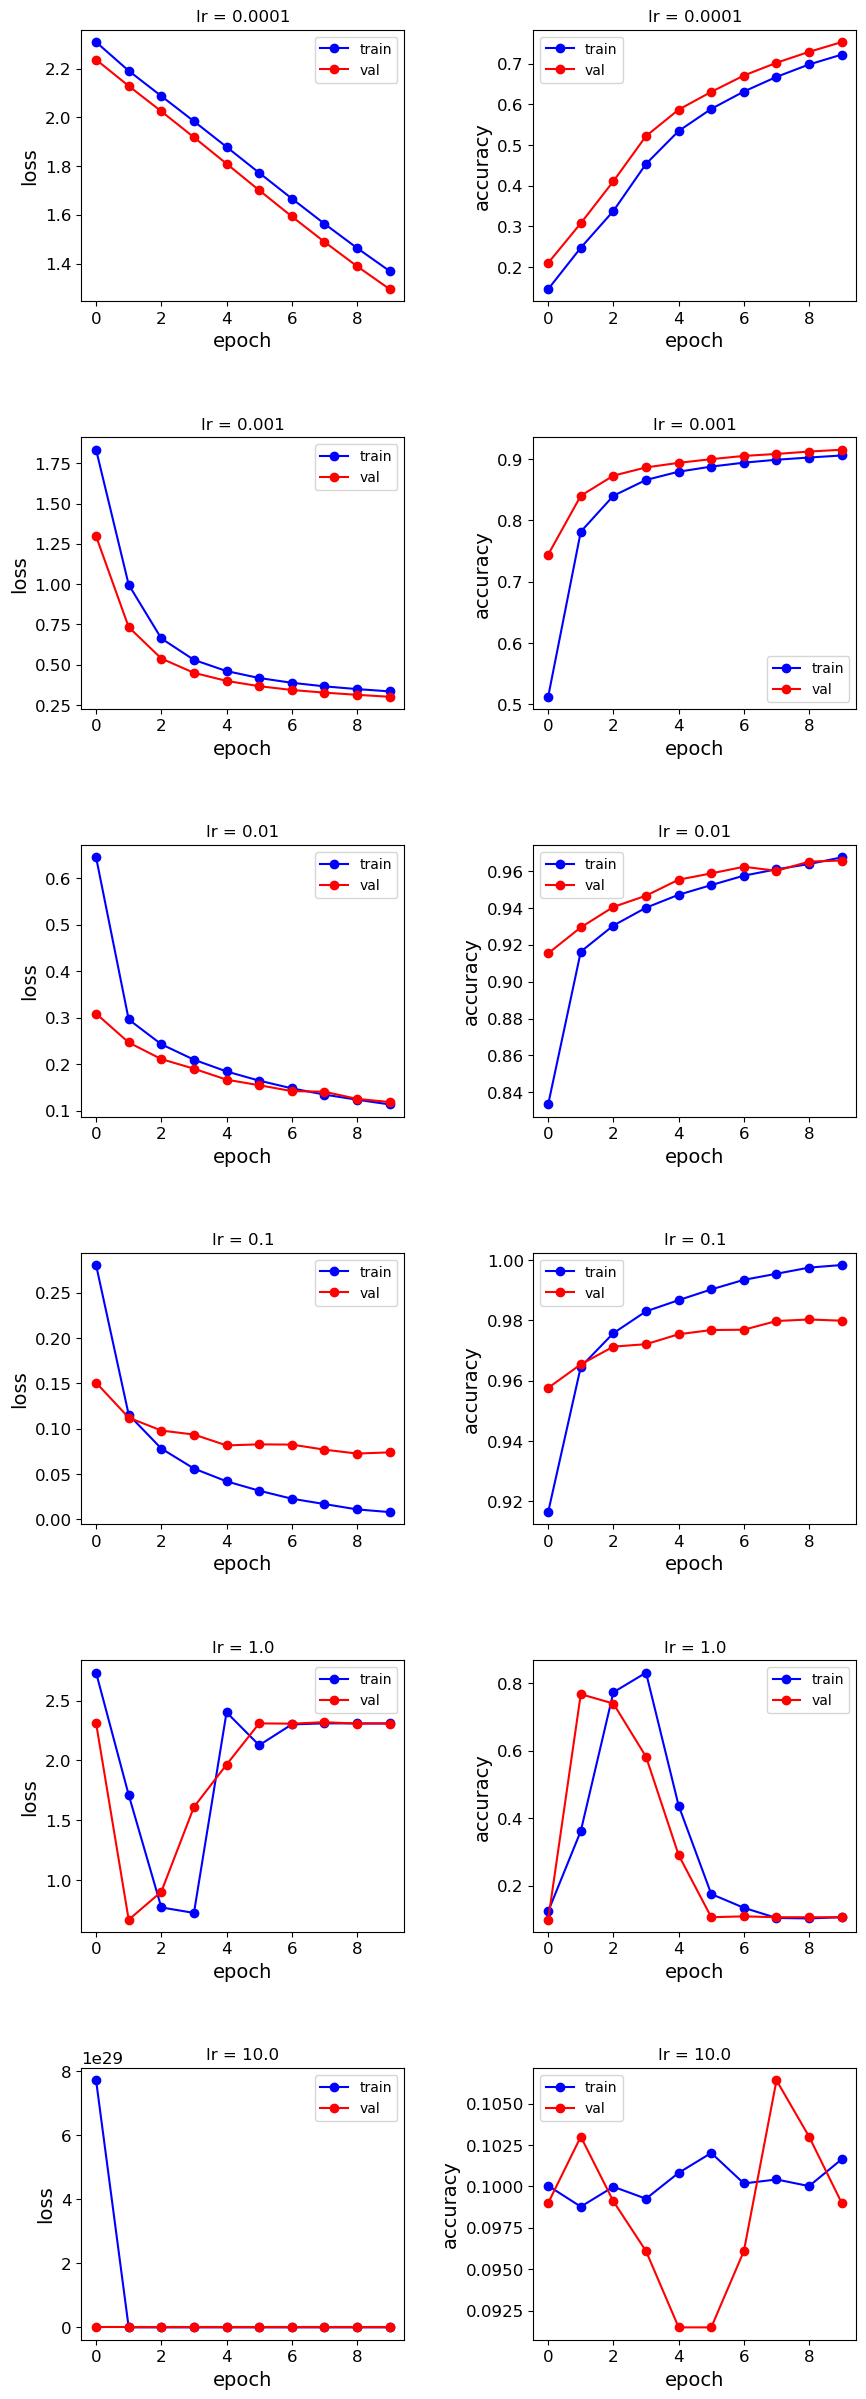

In [127]:
n_rows = counter
n_cols = 2
plt.figure(figsize=(n_cols * 5, n_rows * 5))
for row in range(n_rows):
    index = n_cols * row 
    plt.subplot(n_rows, n_cols, index + 1)
    plt.plot(histories_lr[str(row)]['history']['loss'], 'bo-', label = 'train')
    plt.plot(histories_lr[str(row)]['history']['val_loss'], 'ro-', label = 'val')
    plt.legend()
    plt.title(f"lr = {histories_lr[str(row)]['lr']}")
    plt.ylabel('loss')
    plt.xlabel('epoch')

    plt.subplot(n_rows, n_cols, index + 2)
    plt.plot(histories_lr[str(row)]['history']['sparse_categorical_accuracy'], 'bo-', label = 'train')
    plt.plot(histories_lr[str(row)]['history']['val_sparse_categorical_accuracy'], 'ro-',  label = 'val')
    plt.legend()
    plt.title(f"lr = {histories_lr[str(row)]['lr']}")
    plt.ylabel('accuracy')
    plt.xlabel('epoch')

plt.subplots_adjust(wspace=0.4, hspace=0.5)
plt.show()

Ok, let's try `learn_rate = 0.25,0.5` :

In [146]:
m1 = keras.models.Sequential(
        [
            # 0. input layer: A flatten layer with the shape 28*28. 
            keras.layers.Flatten(
                input_shape = [28,28],
                name = "flatten_input"
            ),
            # 
            # 1. First Hidden layer: 
            keras.layers.Dense(
                units = 300,
                activation = 'relu',
                name = "h1"
            ),
            #
            # 2. Second Hiiden layer
            keras.layers.Dense(
                units = 100,
                activation = 'relu',
                name = 'h2'
            ),
            #
            # 3. output layer with 10 units corresponding to 10 digits. 
            # We use 'softmax' activation function, to get probabilities. 
            keras.layers.Dense(
                units = 10,
                activation = 'softmax',
                name = 'output' 
            )
        ]
    )
# Compile the model 
m1.compile(
    # we could write loss = 'sparse_categorical_crossentropy'
    loss = keras.losses.SparseCategoricalCrossentropy(), 
    #
    # we could write optimizer = 'sgd'
    optimizer = keras.optimizers.SGD(learning_rate = 0.5),
    #
    #
    metrics = [keras.metrics.SparseCategoricalAccuracy()]
)
# fit
m1_history = m1.fit(
    x_train,
    y_train,
    epochs = 100,
    validation_data = (x_valid, y_valid),
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience = 20,
            restore_best_weights = True
        )
    ]
)

Epoch 1/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.2716 - sparse_categorical_accuracy: 0.9167 - val_loss: 0.1344 - val_sparse_categorical_accuracy: 0.9602
Epoch 2/100
1563/1563 [==============================] - 12s 8ms/step - loss: 0.1129 - sparse_categorical_accuracy: 0.9654 - val_loss: 0.1264 - val_sparse_categorical_accuracy: 0.9627
Epoch 3/100
1563/1563 [==============================] - 14s 9ms/step - loss: 0.0795 - sparse_categorical_accuracy: 0.9752 - val_loss: 0.1022 - val_sparse_categorical_accuracy: 0.9722
Epoch 4/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0614 - sparse_categorical_accuracy: 0.9816 - val_loss: 0.0909 - val_sparse_categorical_accuracy: 0.9770
Epoch 5/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.0532 - sparse_categorical_accuracy: 0.9830 - val_loss: 0.0889 - val_sparse_categorical_accuracy: 0.9764
Epoch 6/100
1563/1563 [==============================] - 13s 8ms/step - loss: 0.

Text(0.5, 0, 'epoch')

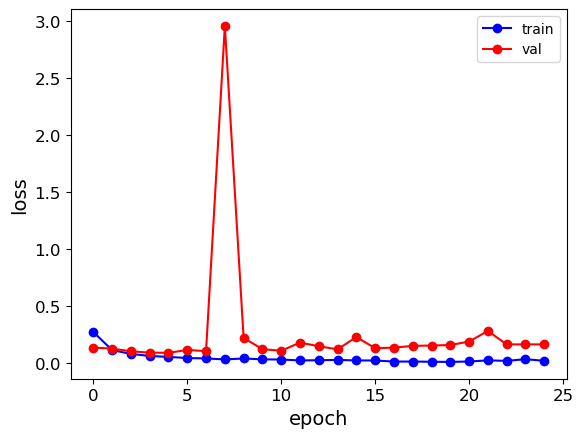

In [147]:
plt.plot(m1.history.history['loss'], 'bo-', label = 'train')
plt.plot(m1.history.history['val_loss'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

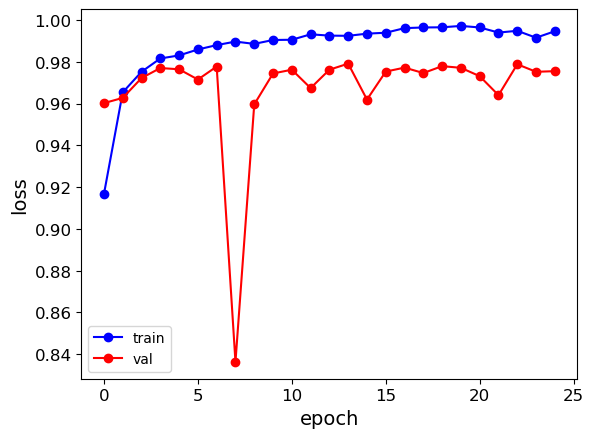

In [148]:
plt.plot(m1.history.history['sparse_categorical_accuracy'], 'bo-', label = 'train')
plt.plot(m1.history.history['val_sparse_categorical_accuracy'], 'ro-', label = 'val')
plt.legend()
#plt.title(f"lr = {histories_lr[str(row)]['lr']}")
plt.ylabel('loss')
plt.xlabel('epoch')

In [149]:
# plt.subplot(n_rows, n_cols, index + 2)
# plt.plot(histories_lr[str(row)]['history']['sparse_categorical_accuracy'], 'bo-', label = 'train')
# plt.plot(histories_lr[str(row)]['history']['val_sparse_categorical_accuracy'], 'ro-',  label = 'val')
# plt.legend()
# plt.title(f"lr = {histories_lr[str(row)]['lr']}")
# plt.ylabel('accuracy')
# plt.xlabel('epoch')